In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [3]:
import numpy as np

def make_blob_and_noise_dist_uniform(n_samples, dist=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[0, 0]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_samples:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_samples * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_samples - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    
    X = np.vstack((X, centers[0] + dist))
    l = np.hstack((l, [-1]))
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
dists = np.arange(0, 15.1, 0.5)
blob_noise_dist_datasets = [
    [make_blob_and_noise_dist_uniform(500, dist=dist, seed=seed) for seed in random_seeds] for dist in dists
]

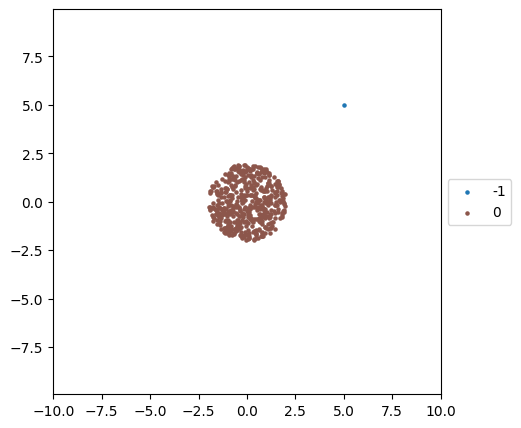

In [4]:
import matplotlib.pyplot as plt


# X, l = make_blobs_dist(500, 5, 0)
X, l = make_blob_and_noise_dist_uniform(500, 5, 0)

plt.figure(figsize=(5, 5))
color = plt.cm.tab20(np.linspace(0, 1, len(set(l)) + 1))
for c_id in np.sort(list(set(l))):
    plt.scatter(
        X[:, 0][l == c_id], X[:, 1][l == c_id], s=5, color=color[int(c_id) + 1], label=int(c_id)
    )
legend = plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
ax = plt.gca()
plt.ylim(-10, 10)
plt.xlim(-10, 10)
ax.set_aspect("equal", adjustable="datalim")

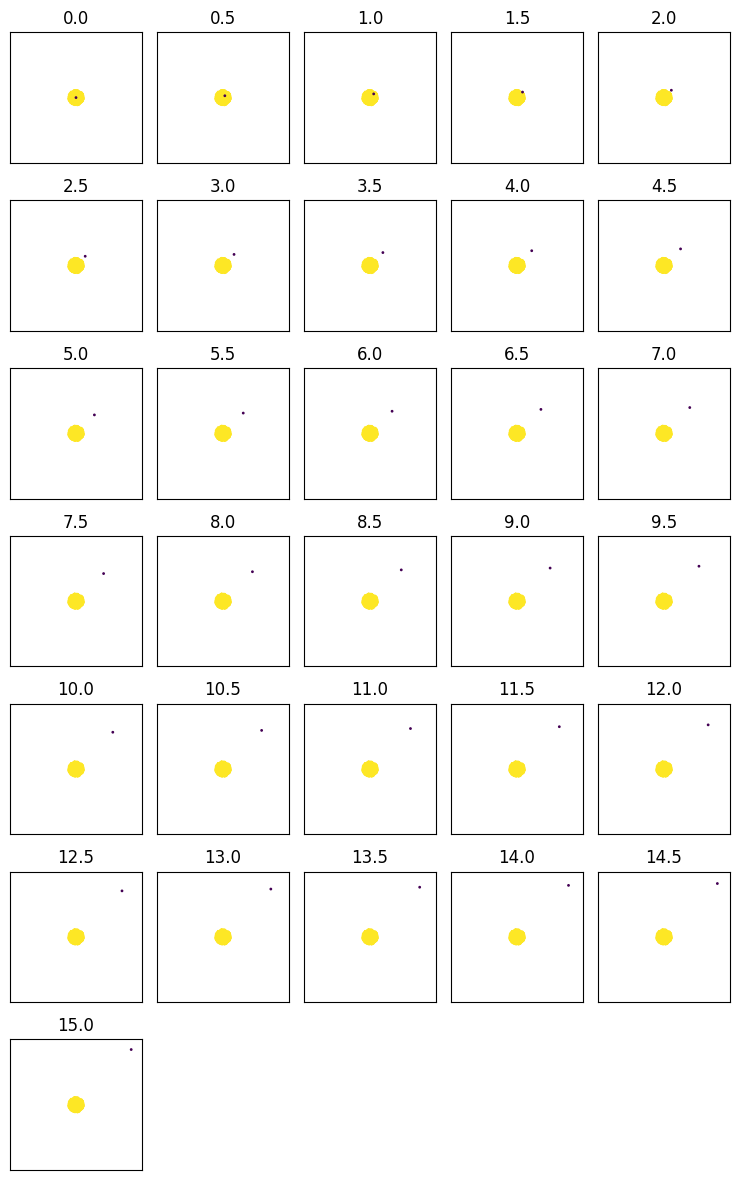

In [5]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets

fig = plot_datasets(blob_noise_dist_datasets, dists, rows=7, cols=5, figsize=1.5)

axes = fig.get_axes()
for ax in axes:
    ax.set_ylim(-20, 20)
    ax.set_xlim(-20, 20)
    ax.set_aspect("equal", adjustable="datalim")

plt.savefig("imgs/Noise_dist_data.png")

In [6]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets, exec_metric
from src.utils.metrics import create_and_filter_df, METRICS, noise_eval

metrics = METRICS.copy()
del metrics["DISCO"]
del metrics["DSI"]
del metrics["S_DBW"]
del metrics["CDBW"]
del metrics["CVNN"]
del metrics["DBCV"]


eval_results = cache(
    "Noise_dist",
    calc_eval_measures_for_multiple_datasets,
    [blob_noise_dist_datasets, dists],
    {"metrics": {"noise_eval": lambda X, l: np.mean(noise_eval(X, l)), **metrics}},
    recalc=False,
)

df = create_and_filter_df(eval_results, selected_metrics=None, excluded_metrics=["CH", "DC_DUNN", "DB", "DUNN"])

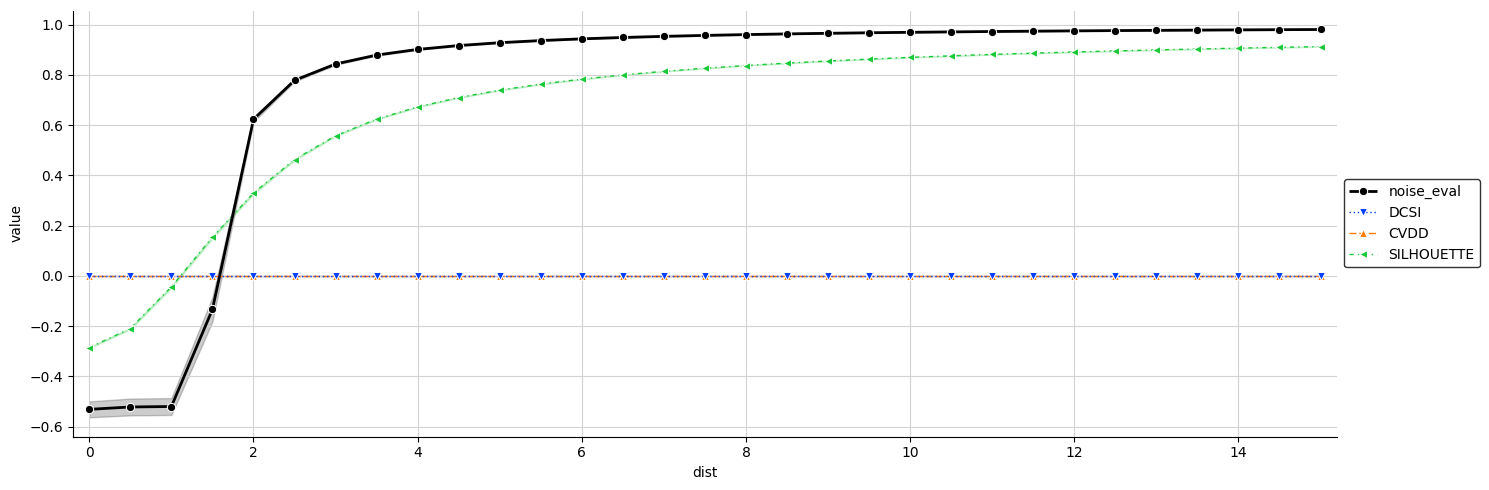

In [7]:
from src.utils.plots import plot_lineplot

eps = 0.2
x_range = dists[0] - eps, dists[-1] + eps
df = df.rename(columns={"dataset": "dist"})

plot_lineplot(df, "dist", "value", "measure", x_range=x_range, y_range=(None, None))
plt.savefig("imgs/Noise_dist.png")

In [8]:
import numpy as np

def make_blob_and_noise_grow_uniform(n_samples, n_noise=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[0, 0], [15, 15]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        if i == 0:
            n_cluster = n_samples
        if i == 1:
            n_cluster = n_noise
        while len(X_i) < n_cluster:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_cluster * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_cluster - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    l[l == 1] = -1
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
n_noises = np.hstack(([1], np.arange(20, 501, 20)))
blob_noise_grow_datasets = [
    [make_blob_and_noise_grow_uniform(500, n_noise=n_noise, seed=seed) for seed in random_seeds]
    for n_noise in n_noises
]

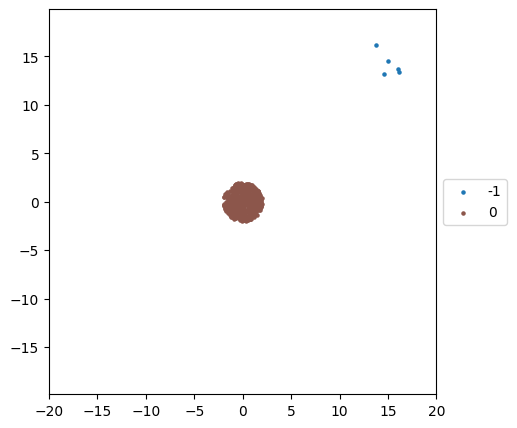

In [9]:
import matplotlib.pyplot as plt


X, l = make_blob_and_noise_grow_uniform(500, 5, 0)

plt.figure(figsize=(5, 5))
color = plt.cm.tab20(np.linspace(0, 1, len(set(l)) + 1))
for c_id in np.sort(list(set(l))):
    plt.scatter(
        X[:, 0][l == c_id], X[:, 1][l == c_id], s=5, color=color[int(c_id) + 1], label=int(c_id)
    )
legend = plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
ax = plt.gca()
plt.ylim(-20, 20)
plt.xlim(-20, 20)
ax.set_aspect("equal", adjustable="datalim")

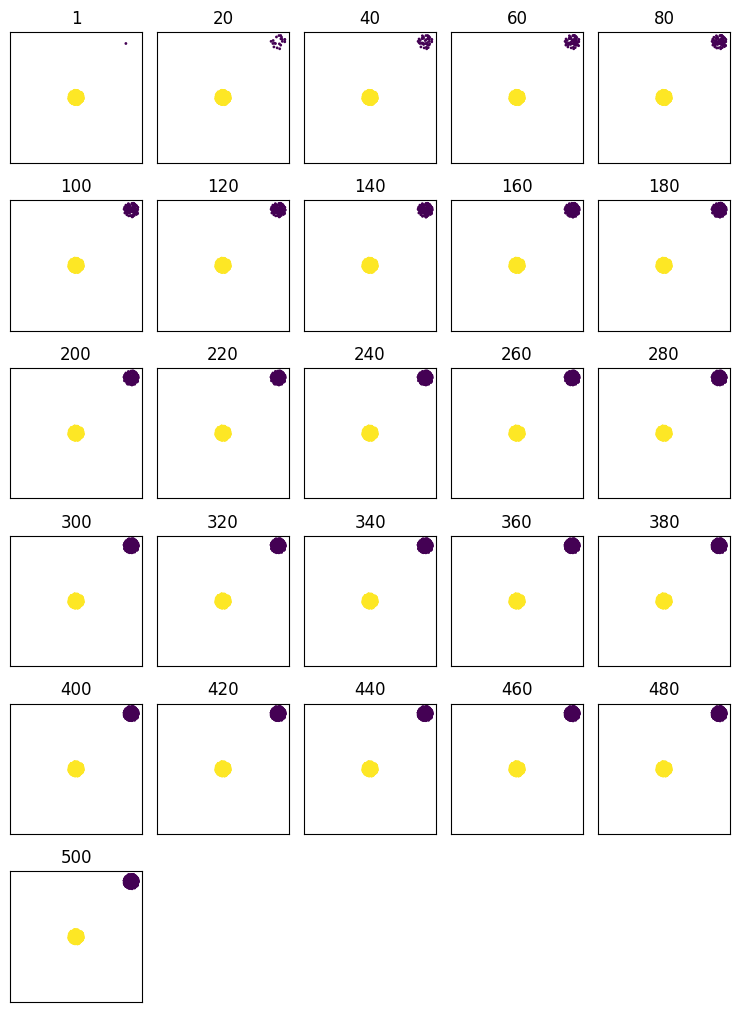

In [10]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets

fig = plot_datasets(blob_noise_grow_datasets, n_noises, rows=7, cols=5, figsize=1.5)

axes = fig.get_axes()
for ax in axes:
    ax.set_ylim(-20, 20)
    ax.set_xlim(-20, 20)
    ax.set_aspect("equal", adjustable="datalim")

plt.savefig("imgs/Noise_grow_data.png")

In [11]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets, exec_metric
from src.utils.metrics import create_and_filter_df, METRICS, noise_eval

metrics = METRICS.copy()
del metrics["DISCO"]
del metrics["DSI"]
del metrics["S_DBW"]
del metrics["CDBW"]
del metrics["CVNN"]
del metrics["DBCV"]


eval_results = cache(
    "Noise_grow",
    calc_eval_measures_for_multiple_datasets,
    [blob_noise_grow_datasets, n_noises],
    {"metrics": {"noise_eval": lambda X, l: np.mean(noise_eval(X, l)), **metrics}},
    recalc=False,
)

df = create_and_filter_df(eval_results, selected_metrics=None, excluded_metrics=["CH", "DC_DUNN", "DB", "DUNN"])

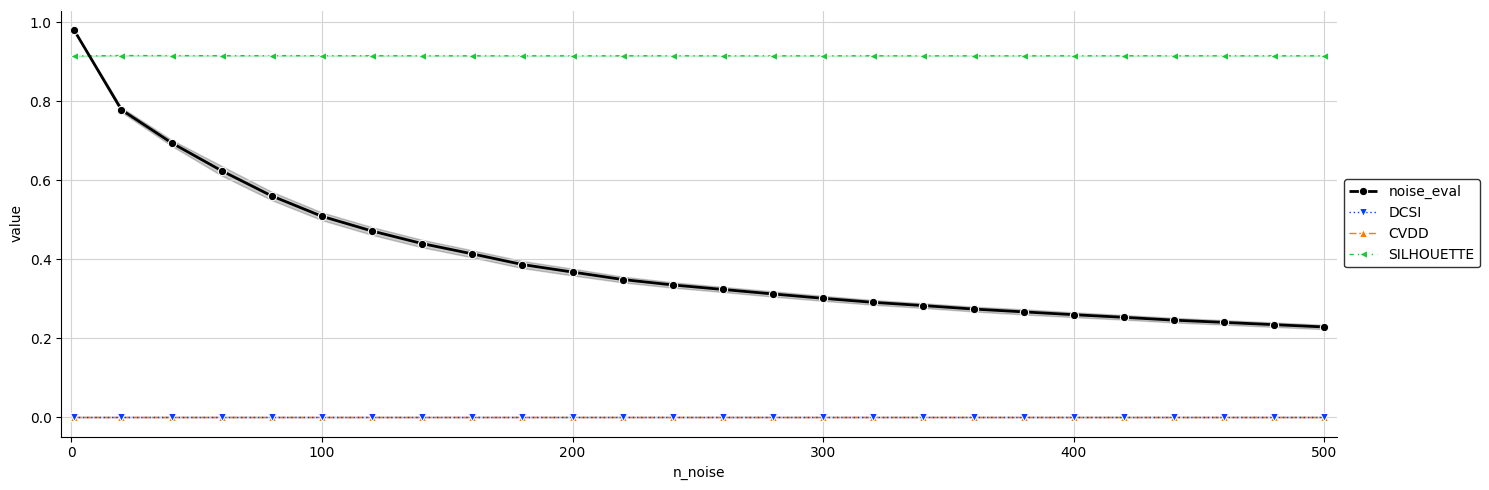

In [12]:
from src.utils.plots import plot_lineplot

eps = 5
x_range = n_noises[0] - eps, n_noises[-1] + eps
df = df.rename(columns={"dataset": "n_noise"})

plot_lineplot(df, "n_noise", "value", "measure", x_range=x_range, y_range=(None, None))
plt.savefig("imgs/Noise_grow.png")